# Question 4
Predict the Top Complaint Type

# Imports + Options

In [1]:
# Normal data analysis packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML packages 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 40

sns.set_style('whitegrid')

# Data

## Data Imports

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '18iT4frO_59vyr_xk8I2rhHBrfibVjIDD'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df311_final_v2.pkl')  
df311_final = pd.read_pickle('df311_final_v2.pkl')

In [4]:
df311_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83487 entries, 0 to 89852
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeatingComplaint  83487 non-null  float64
 1   LotArea           83487 non-null  int64  
 2   BldgArea          83487 non-null  int64  
 3   ComArea           83487 non-null  int64  
 4   ResArea           83487 non-null  int64  
 5   OfficeArea        83487 non-null  int64  
 6   RetailArea        83487 non-null  int64  
 7   GarageArea        83487 non-null  int64  
 8   StrgeArea         83487 non-null  int64  
 9   FactryArea        83487 non-null  int64  
 10  OtherArea         83487 non-null  int64  
 11  NumBldgs          83487 non-null  int64  
 12  NumFloors         83487 non-null  float64
 13  UnitsRes          83487 non-null  int64  
 14  UnitsTotal        83487 non-null  int64  
 15  LotFront          83487 non-null  float64
 16  LotDepth          83487 non-null  float6

# Model Evaluation

## Train/ Test Split

In [0]:
X = df311_final.drop('HeatingComplaint',axis=1)
y = df311_final['HeatingComplaint']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
X_s = scaler.fit_transform(X)
X_s = scaler.transform(X)

## Cross Val

In [8]:
#Cannot run on full dataset
cross_val_score(SVC(kernel='linear',C=5,gamma='auto'),X=X_test[0:10000],y=y_test[0:10000],cv=10,scoring='f1_weighted').mean()

0.818581146469209

In [9]:
cross_val_score(LinearSVC(C=1, max_iter=4000),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.8164642543490732

In [10]:
cross_val_score(SGDClassifier(),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.8028126004474794

In [11]:
cross_val_score(LogisticRegression(max_iter=500),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.813886263406529

In [12]:
cross_val_score(DecisionTreeClassifier(),X=X_s,y=y,cv=10,scoring='f1_weighted').mean()

0.6570426524399859

In [13]:
cross_val_score(RandomForestClassifier(n_estimators=20),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.7360235315573942

In [15]:
cross_val_score(XGBClassifier(),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.8105439342951527

## Hyper Param Tuning

## Grid Search for LinearSVC

In [16]:
SVC_grid = GridSearchCV(LinearSVC(max_iter=2000),{
    'C': [1,2,3,4,5,6,7,8],
}, verbose=0)
SVC_grid.fit(X_train[0:5000],y_train[0:5000])

SVC_grid.best_params_

{'C': 5}

In [17]:
cross_val_score(LinearSVC(max_iter=2000,C=5),X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.8170056481923496

## Grid Search for XGB

In [29]:
params = {
    'learning rate': [0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth': [3,4,5,6,8,10,12],
    'min_child_weight': [1,3,5,7],
    'gamma': [0.0,0.1,0.2,0.3,0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.7]
}

XGB_rs = RandomizedSearchCV(XGBClassifier(), param_distributions=params,n_iter=5,scoring='f1_weighted',n_jobs=-1,cv=5)

XGB_rs.fit(X,y)

XGB_rs.best_params_


{'colsample_bytree': 0.5,
 'gamma': 0.1,
 'learning rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 7}

In [31]:
XGB_rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning rate=0.2, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [34]:
classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

cross_val_score(classifier,X=X_s,y=y,cv=10, scoring='f1_weighted').mean()

0.7889091824212633

## Voting Classifier

In [0]:
lsvc = LinearSVC(C=5, max_iter=2000)
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
              learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=7, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)
log_reg = LogisticRegression(max_iter=500)

In [0]:
evc = VotingClassifier(estimators = [('lsvc',lsvc), ('xgb',xgb), ('log_reg', log_reg)], voting = 'hard')

In [37]:
evc.fit(X_train,y_train)

VotingClassifier(estimators=[('lsvc',
                              LinearSVC(C=5, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=2000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5, gamma=0.1,
                                            le...
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1)),
                     

In [38]:
evc.score(X_test, y_test)

0.8525571924781411

In [0]:
predictions = evc.predict(X_test)

In [40]:
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

0.8525571924781411
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     19866
         1.0       0.76      0.42      0.54      5181

    accuracy                           0.85     25047
   macro avg       0.81      0.69      0.73     25047
weighted avg       0.84      0.85      0.84     25047

[[19194   672]
 [ 3021  2160]]


## Stacking Classifier

In [0]:
esc = StackingClassifier(estimators = [('lsvc',lsvc), ('log_reg', log_reg)], final_estimator = xgb)

In [42]:
esc.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('lsvc',
                                LinearSVC(C=5, class_weight=None, dual=True,
                                          fit_intercept=True,
                                          intercept_scaling=1,
                                          loss='squared_hinge', max_iter=2000,
                                          multi_class='ovr', penalty='l2',
                                          random_state=None, tol=0.0001,
                                          verbose=0)),
                               ('log_reg',
                                LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=No...
                                                 colsamp

In [0]:
predictions = esc.predict(X_test)

In [44]:
print(esc.score(X_test, y_test))
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

0.8494430470715055
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     19866
         1.0       0.75      0.40      0.53      5181

    accuracy                           0.85     25047
   macro avg       0.81      0.68      0.72     25047
weighted avg       0.84      0.85      0.83     25047

[[19186   680]
 [ 3091  2090]]


# Prediction Using Tensorflow

In [0]:
X = df311_final.drop('HeatingComplaint',axis=1).values
y = df311_final['HeatingComplaint'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
df311_final.shape

(83487, 51)

## Model 1:
* Dense / 51
* Dropout

* Dense / 26
* Dropout 

* Dense / 1
* sigmoid

In [0]:
model = Sequential()

# input layer
model.add(Dense(51,activation='relu'))
model.add(Dropout(0.2))

# hidden layer 1
model.add(Dense(26,activation='relu'))
model.add(Dropout(0.2))

#Binary classification
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')

In [48]:
model.fit(x=X_train,y=y_train,epochs=25,validation_data=(X_test,y_test))

Epoch 1/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.4073 - val_loss: 0.3844
Epoch 2/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3884 - val_loss: 0.3812
Epoch 3/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3830 - val_loss: 0.3795
Epoch 4/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3815 - val_loss: 0.3766
Epoch 5/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3789 - val_loss: 0.3736
Epoch 6/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3765 - val_loss: 0.3724
Epoch 7/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3748 - val_loss: 0.3716
Epoch 8/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3741 - val_loss: 0.3720
Epoch 9/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3731 - val_loss: 0.3718
Epoch 10/25
1827/1827 [==============================] - 5s 3ms/step - loss: 0.372

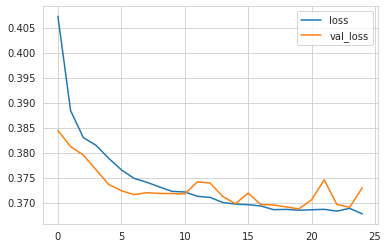

In [49]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

### Model 1 Results:

In [50]:
predictions = model.predict_classes(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.8527568171836947
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     19866
         1.0       0.80      0.38      0.52      5181

    accuracy                           0.85     25047
   macro avg       0.83      0.68      0.72     25047
weighted avg       0.85      0.85      0.83     25047

[[19384   482]
 [ 3206  1975]]


## Model 2:
* Dense / 51

* Dense / 26
* Dropout 

* Dense / 1
* sigmoid

In [51]:
model2 = Sequential()

# input layer
model2.add(Dense(51,activation='relu'))
#model.add(Dropout(0.2))

# hidden layer 1
model2.add(Dense(26,activation='relu'))
model2.add(Dropout(0.2))

#Binary classification
model2.add(Dense(1,activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer='adam')

model2.fit(x=X_train,y=y_train,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.4014 - val_loss: 0.3851
Epoch 2/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3847 - val_loss: 0.3803
Epoch 3/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3805 - val_loss: 0.3771
Epoch 4/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3781 - val_loss: 0.3740
Epoch 5/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3754 - val_loss: 0.3725
Epoch 6/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3737 - val_loss: 0.3732
Epoch 7/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3725 - val_loss: 0.3697
Epoch 8/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3721 - val_loss: 0.3747
Epoch 9/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3709 - val_loss: 0.3703
Epoch 10/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.369

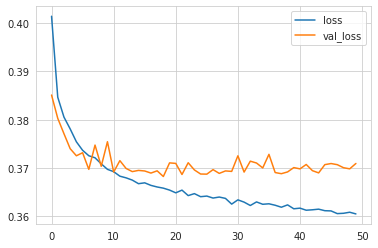

In [52]:
model2_loss = pd.DataFrame(model2.history.history)
model2_loss.plot()

### Model 2 Results:

In [53]:
predictions2 = model2.predict_classes(X_test)

print(accuracy_score(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))

0.8543538148281231
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     19866
         1.0       0.76      0.43      0.55      5181

    accuracy                           0.85     25047
   macro avg       0.81      0.70      0.73     25047
weighted avg       0.84      0.85      0.84     25047

[[19159   707]
 [ 2941  2240]]


## Model 3:
* Dense / 51

* Dense / 26
* Dropout 

* Dense / 26
* Dropout 

* Dense / 1
* sigmoid

In [55]:
model3 = Sequential()

# input layer
model3.add(Dense(51,activation='relu'))

# hidden layer 1
model3.add(Dense(26,activation='relu'))
model3.add(Dropout(0.2))

# hidden layer 2
model3.add(Dense(26,activation='relu'))
model3.add(Dropout(0.2))

#Binary classification
model3.add(Dense(1,activation='sigmoid'))

model3.compile(loss='binary_crossentropy',optimizer='adam')

early_stopping_monitor = EarlyStopping(patience=3)

model3.fit(x=X_train,y=y_train,epochs=50,validation_data=(X_test,y_test), callbacks=[early_stopping_monitor])

Epoch 1/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.4040 - val_loss: 0.3904
Epoch 2/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3858 - val_loss: 0.3806
Epoch 3/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3818 - val_loss: 0.3762
Epoch 4/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3789 - val_loss: 0.3736
Epoch 5/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3762 - val_loss: 0.3724
Epoch 6/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3748 - val_loss: 0.3711
Epoch 7/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3734 - val_loss: 0.3745
Epoch 8/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3717 - val_loss: 0.3712
Epoch 9/50
1827/1827 [==============================] - 5s 3ms/step - loss: 0.3717 - val_loss: 0.3720


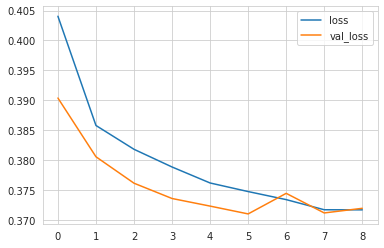

In [56]:
model3_loss = pd.DataFrame(model3.history.history)
model3_loss.plot()

### Model 3 Results:

In [57]:
predictions3 = model3.predict_classes(X_test)

print(accuracy_score(y_test, predictions3))
print(classification_report(y_test, predictions3))
print(confusion_matrix(y_test, predictions3))

0.852716892242584
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     19866
         1.0       0.75      0.43      0.55      5181

    accuracy                           0.85     25047
   macro avg       0.81      0.70      0.73     25047
weighted avg       0.84      0.85      0.84     25047

[[19131   735]
 [ 2954  2227]]


# Conclusions

The best ML model consisted of a voting ensemble between Linear SVC, Logistic Regression, and XG Boost. The results from this model gave a weighted F1 score of 0.84 with the following confusion matrix: 
```
[[19194   672] 
 [ 3021  2160]]
```
The best NN model consisted of a dense input layer, a 2 hidden layers, both with dropout, and an output layer. The results from this model gave a weighted F1 score of 0.84 with the following confusion matrix: 
```
[[19131   735]
 [ 2954  2227]]
```
The correct estimations are very close between both models and show an improvement of ~70 more correct estimations companred to V1. The weakness of the model is still in overfitting and underestimating the number of complaints. The next step would be to further look into the data.
